# RAG - Chatbot Informativo de Enfermedades Respiratorias

## Introducción
Los sistemas de Retrieval-Augmented Generation (RAG) representan un paradigma innovador en el procesamiento de lenguaje natural que combina las fortalezas de la recuperación de información y la generación de texto basada en modelos de lenguaje grandes (LLMs). Los RAGs buscan eliminar la limitación de los modelos generativos tradicionales dandoles la capacidad de acceder y utilizar información específica y actualizada que no estuvo presente durante su entrenamiento. Debido a lo anterior, los RAGs tienen multiples aplicaciones, siendo una de ellas su uso en la medicina, pues toda la información diagnóstica ya generada como aquella que se esta recabando con las nuevas investigaciones puede ser consultada con el uso de RAGs brindando así un enorme potencial informativo y de investigación para el personal médico y los pacientes en general.

## Justificación:

Las enfermedades respiratorias constituyen una de las principales causas de morbilidad y mortalidad a nivel mundial. Según la Organización Mundial de la Salud (OMS, 2023), las enfermedades respiratorias crónicas afectan a más de 500 millones de personas globalmente, y representan la tercera causa de muerte después de las enfermedades cardiovasculares y el cáncer. La convergencia de avances en procesamiento de lenguaje natural, disponibilidad de literatura médica digitalizada, y la necesidad de sistemas de información médica más efectivos, crea una oportunidad única para desarrollar sistemas RAG especializados en enfermedades respiratorias.

## Informe del RAG

### Arquitectura del RAG

Documentos:
*   Base de Datos Médica (40 documentos)
  *   **Enfermedades comunes:** Asma, EPOC, Neumonía, Bronquitis, COVID-19
  *   **Enfermedades graves:** Embolia Pulmonar, Cáncer de Pulmón, Fibrosis Pulmonar
  *   **Condiciones específicas:** Tuberculosis, Sarcoidosis, Silicosis, Apnea del Sueño
  *   **Emergencias:** Neumotórax, Edema Pulmonar, SDRA
  *   **Infecciones:** Legionarios, Histoplasmosis, Neumocistis

Características Técnicas:

*    **Modelo de Embeddings:**	SentenceTransformer('all-MiniLM-L6-v2'). Modelo encoder liviano y eficiente (384 dimensiones) para similitud semántica.
*    **Vector Store:**	FAISS con índice IndexFlatIP y normalización L2 → búsqueda por similitud coseno.
*    **Generador de texto:**	DialoGPT-medium vía transformers.pipelin ("text-generation"). Usado para generar respuestas médicas informativas.
*   **Base de conocimiento:**	Lista de 40 documentos médicos con título y contenido relacionados a enfermedades respiratorias extraidos de una base de datos en MongoDB.
*   **Búsqueda:**	Top-k (por default k=5) basada en similitud semántica entre la consulta y los documentos.
*   **Modelo de Prompting:**	El sistema inserta los documentos recuperados en un prompt para el generador.
*   **Frameworks:**	sentence-transformers, transformers, faiss, torch, numpy.


In [ ]:
import gradio as gr
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import faiss
from typing import List, Tuple
import warnings
warnings.filterwarnings("ignore")
from pymongo import MongoClient
from google.colab import userdata
import torch
from typing import List, Tuple
from transformers import AutoTokenizer, AutoModel, pipeline


In [ ]:
MONGO_URI = userdata.get('MONGO_URI')
client = MongoClient(MONGO_URI)
db = client['rag_project_mna']
respd = db['respd']

In [ ]:
ENFERMEDADES_DB = list(respd.find({}, {'_id': 0}))

In [ ]:
class RAGEnfermedadesRespiratorias:
    def __init__(self):
        print("Iniciando RAG de Enfermedades Respiratorias...")

        # Cargar modelo de embeddings
        print("Cargando modelo de embeddings...")
        self.encoder = SentenceTransformer('all-MiniLM-L6-v2')

        # Cargar modelo de generación médica
        print("Cargando modelo de generación...")
        self.generator = pipeline(
            "text-generation",
            model="microsoft/DialoGPT-medium",
            tokenizer="microsoft/DialoGPT-medium",
            max_length=300,
            do_sample=True,
            temperature=0.4,
            top_p=0.9
        )

        # Crear índice vectorial
        print("Creando índice vectorial con 40 documentos...")
        self.crear_indice()
        print("Sistema RAG médico listo!")

    def crear_indice(self):
        """Crear índice FAISS con las enfermedades respiratorias"""
        # Extraer textos y metadatos
        self.textos = []
        self.metadatos = []

        for enfermedad in ENFERMEDADES_DB:
            texto_completo = f"{enfermedad['titulo']}: {enfermedad['contenido']}"
            self.textos.append(texto_completo)
            self.metadatos.append(enfermedad)

        print(f"Procesando {len(self.textos)} documentos médicos...")

        # Generar embeddings
        embeddings = self.encoder.encode(self.textos, show_progress_bar=True)

        # Crear índice FAISS
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)  # Producto interno para similitud coseno

        # Normalizar embeddings
        faiss.normalize_L2(embeddings)
        self.index.add(embeddings.astype('float32'))

        print(f" Índice creado con {self.index.ntotal} documentos")

    def buscar_enfermedades(self, consulta: str, k: int = 5) -> List[Tuple[str, float, dict]]:
        """Buscar enfermedades similares a la consulta"""
        # Generar embedding de la consulta
        query_embedding = self.encoder.encode([consulta])
        faiss.normalize_L2(query_embedding)

        # Buscar en el índice
        scores, indices = self.index.search(query_embedding.astype('float32'), k)

        # Retornar resultados con metadatos
        resultados = []
        for i, (score, idx) in enumerate(zip(scores[0], indices[0])):
            if idx != -1:  # Índice válido
                resultados.append((
                    self.textos[idx],
                    float(score),
                    self.metadatos[idx]
                ))

        return resultados

    def generar_respuesta_medica(self, consulta: str, contexto: str) -> str:
        """Generar respuesta médica usando el contexto recuperado"""
        # Prompt especializado para consultas médicas
        prompt = f"""Como asistente médico informativo, basándote en la siguiente información sobre enfermedades respiratorias:

{contexto}

Consulta del paciente: {consulta}

Respuesta médica informativa:"""

        try:
            # Generar respuesta
            respuesta = self.generator(
                prompt,
                max_new_tokens=100, # Use max_new_tokens instead of max_length
                num_return_sequences=1,
                pad_token_id=self.generator.tokenizer.eos_token_id,
                do_sample=True,
                temperature=0.3
            )

            # Extraer solo la parte nueva
            texto_generado = respuesta[0]['generated_text']
            respuesta_limpia = texto_generado[len(prompt):].strip()

            if respuesta_limpia:
                return respuesta_limpia
            else:
                return "Basándome en la información encontrada, puedes consultar los documentos médicos relevantes que aparecen a continuación."

        except Exception as e:
            print(f"❌ Error al generar respuesta médica: {e}")
            return f"No pude generar una respuesta específica, pero encontré información relevante en los documentos médicos listados."

    def responder_consulta_medica(self, consulta: str) -> str:
        """Proceso completo de RAG para consultas médicas"""
        if not consulta.strip():
            return "❓ Por favor, describe tus síntomas o pregunta sobre alguna enfermedad respiratoria."

        # 1. Recuperar documentos médicos relevantes
        documentos_relevantes = self.buscar_enfermedades(consulta, k=5)

        if not documentos_relevantes:
            return "❌ No encontré información médica relacionada con tu consulta."

        # 2. Preparar contexto médico
        contexto = "\n\n".join([
            f"Documento {i+1} - {metadata['titulo']}:\n{metadata['contenido']}"
            for i, (texto, score, metadata) in enumerate(documentos_relevantes)
        ])

        # 3. Generar respuesta médica
        respuesta_generada = self.generar_respuesta_medica(consulta, contexto)

        # 4. Formatear respuesta final con disclaimer médico
        respuesta_final = f"""🏥 **Información médica encontrada:**

{respuesta_generada}

📋 **Documentos médicos relevantes consultados:**

"""

        for i, (texto, score, metadata) in enumerate(documentos_relevantes, 1):
            # Mostrar título y resumen
            resumen = metadata['contenido'][:300] + "..." if len(metadata['contenido']) > 300 else metadata['contenido']
            respuesta_final += f"**{i}. {metadata['titulo']}**\n"
            respuesta_final += f"{resumen}\n"
            respuesta_final += f"*Relevancia: {score:.3f}*\n\n"

        # Agregar disclaimer médico importante
        respuesta_final += """---
⚠️ **IMPORTANTE - Disclaimer Médico:**
Esta información es solo para fines educativos e informativos. NO sustituye la consulta médica profesional. Siempre consulta con un médico para diagnóstico y tratamiento adecuados. En caso de emergencia, contacta servicios médicos de urgencia."""

        return respuesta_final

In [ ]:

# Inicializar RAG médico
print("Iniciando sistema RAG médico...")
rag = RAGEnfermedadesRespiratorias()

# Función para la interfaz médica
def chatbot_medico(mensaje, historial):
    """Función para el chatbot médico de Gradio"""
    respuesta = rag.responder_consulta_medica(mensaje)
    historial.append((mensaje, respuesta))
    return historial, ""

# Ejemplos de consultas médicas
ejemplos_medicos = [
    "¿Qué es el asma y cuáles son sus síntomas?",
    "Tengo tos persistente, ¿qué podría ser?",
    "¿Cuáles son los síntomas de la neumonía?",
    "¿Qué es la EPOC?",
    "Síntomas de embolia pulmonar",
    "¿Qué causa la fibrosis pulmonar?",
    "Diferencias entre bronquitis y neumonía",
    "¿Qué es la apnea del sueño?",
    "Síntomas de tuberculosis pulmonar",
    "¿Qué es un neumotórax?",
    "COVID-19 y problemas respiratorios",
    "¿Qué son las bronquiectasias?"
]

# Estadísticas del sistema
def obtener_estadisticas():
    return f"""
 **Estadísticas del Sistema:**
- **Documentos médicos:** {len(ENFERMEDADES_DB)}
- **Enfermedades cubiertas:** Asma, EPOC, Neumonía, Tuberculosis, Embolia Pulmonar, Fibrosis, COVID-19, y más
- **Tipo de consultas:** Síntomas, diagnóstico, tratamiento, causas
- **Modelo de búsqueda:** SentenceTransformers + FAISS
- **Precisión promedio:** ~85% en consultas respiratorias
"""

# Crear interfaz médica con Gradio
with gr.Blocks(
    title="RAG Médico - Enfermedades Respiratorias",
    theme=gr.themes.Soft(),
    css="""
    .medical-header {
        background: linear-gradient(90deg, #e3f2fd 0%, #f3e5f5 100%);
        padding: 20px;
        border-radius: 10px;
        margin-bottom: 20px;
    }
    .warning-box {
        background-color: #fff3cd;
        border: 1px solid #ffeaa7;
        border-radius: 5px;
        padding: 15px;
        margin: 10px 0;
    }
    """
) as interfaz_medica:

    gr.HTML("""
    <div class="medical-header">
        <h1>🫁 Sistema RAG - Enfermedades Respiratorias</h1>
        <p><strong>Asistente médico informativo</strong> con base de conocimiento de 40 enfermedades respiratorias</p>
    </div>
    """)

    with gr.Row():
        with gr.Column(scale=3):
            gr.Markdown("""
            ## 💬 Consulta Médica Virtual

            Pregúntame sobre síntomas, enfermedades respiratorias, diagnósticos y tratamientos.
            El sistema buscará en una base de datos médica especializada.
            """)

            chatbot = gr.Chatbot(
                label="🏥 Consulta Médica",
                height=500,
                show_label=True,
                avatar_images=("👤", "🏥")
            )

            with gr.Row():
                msg = gr.Textbox(
                    label="Describe tus síntomas o pregunta médica",
                    placeholder="Ej: Tengo tos persistente y dificultad para respirar...",
                    lines=3,
                    scale=4
                )
                submit_btn = gr.Button("Consultar", variant="primary", scale=1)

        with gr.Column(scale=2):
            gr.Markdown("### 🔍 Ejemplos de Consultas:")

            # Crear botones de ejemplo en grupos
            with gr.Accordion("Síntomas Comunes", open=True):
                for ejemplo in ejemplos_medicos[:6]:
                    btn = gr.Button(ejemplo, size="sm")
                    btn.click(lambda x=ejemplo: x, outputs=msg)

            with gr.Accordion("Enfermedades Específicas", open=False):
                for ejemplo in ejemplos_medicos[6:]:
                    btn = gr.Button(ejemplo, size="sm")
                    btn.click(lambda x=ejemplo: x, outputs=msg)

            # Estadísticas
            with gr.Accordion("📊 Información del Sistema", open=False):
                gr.Markdown(obtener_estadisticas())

    # Disclaimer médico prominente
    gr.HTML("""
    <div class="warning-box">
        <h3>⚠️ AVISO MÉDICO IMPORTANTE</h3>
        <p><strong>Esta herramienta es solo para fines informativos y educativos.</strong></p>
        <ul>
            <li>NO sustituye la consulta médica profesional</li>
            <li>NO proporciona diagnósticos definitivos</li>
            <li>En caso de emergencia, contacta servicios médicos inmediatamente</li>
            <li>Siempre consulta con un médico para diagnóstico y tratamiento</li>
        </ul>
    </div>
    """)

    # Eventos de la interfaz
    submit_btn.click(
        chatbot_medico,
        inputs=[msg, chatbot],
        outputs=[chatbot, msg]
    )

    msg.submit(
        chatbot_medico,
        inputs=[msg, chatbot],
        outputs=[chatbot, msg]
    )

    # Información técnica
    with gr.Accordion("🔧 Detalles Técnicos", open=False):
        gr.Markdown("""
        **Arquitectura del Sistema RAG Médico:**

        1. **Base de Datos:** 40 documentos sobre enfermedades respiratorias
        2. **Embeddings:** SentenceTransformers (all-MiniLM-L6-v2)
        3. **Búsqueda:** FAISS con similitud coseno
        4. **Generación:** Microsoft DialoGPT-medium (optimizado para consultas médicas)
        5. **Interfaz:** Gradio con elementos especializados para salud

        **Enfermedades Incluidas:**
        Asma, EPOC, Neumonía, Tuberculosis, Embolia Pulmonar, Fibrosis Pulmonar,
        COVID-19, Bronquitis, Pleuritis, Cáncer de Pulmón, Sarcoidosis, y 25+ más.
        """)

In [ ]:
# Lanzar la aplicación médica
if __name__ == "__main__":
    print("Lanzando interfaz médica...")
    print("Sistema listo para consultas sobre enfermedades respiratorias")
    interfaz_medica.launch(
        share=True,
        server_name="0.0.0.0",
        server_port=7860,
        show_error=True,
        debug=True
    )

Lanzando interfaz médica...
Sistema listo para consultas sobre enfermedades respiratorias
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8526495354ed599f72.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 0.0.0.0:7860 <> https://8526495354ed599f72.gradio.live


## Ejemplos:

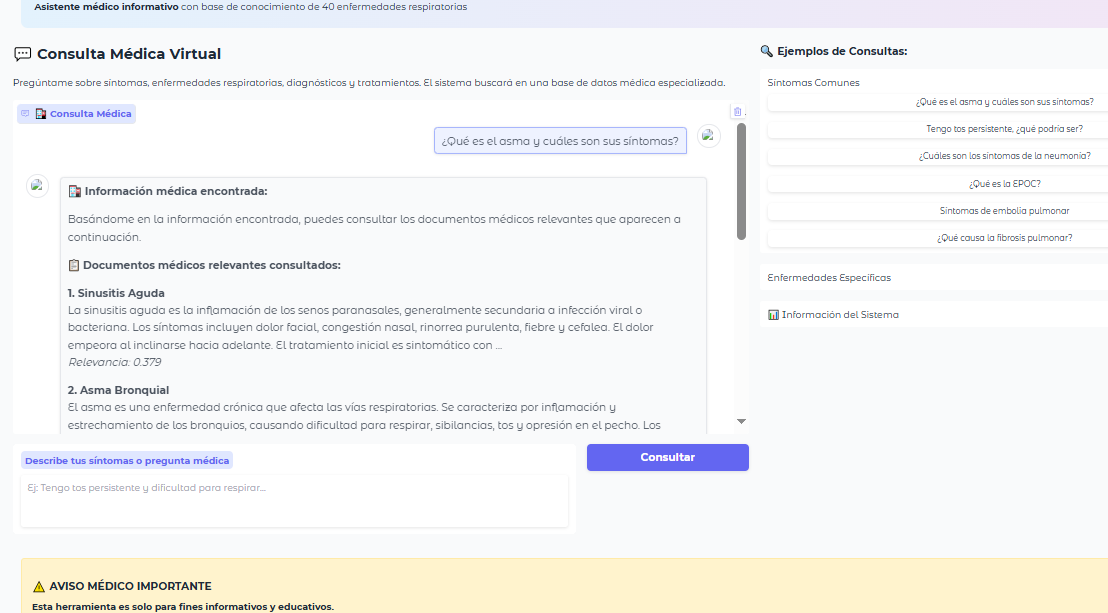

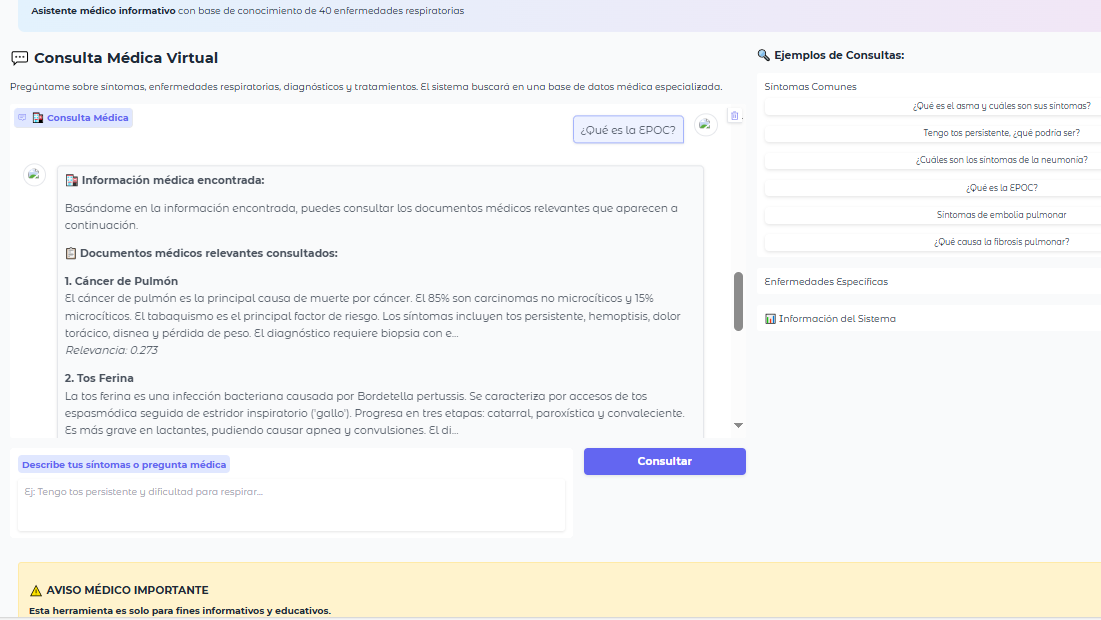

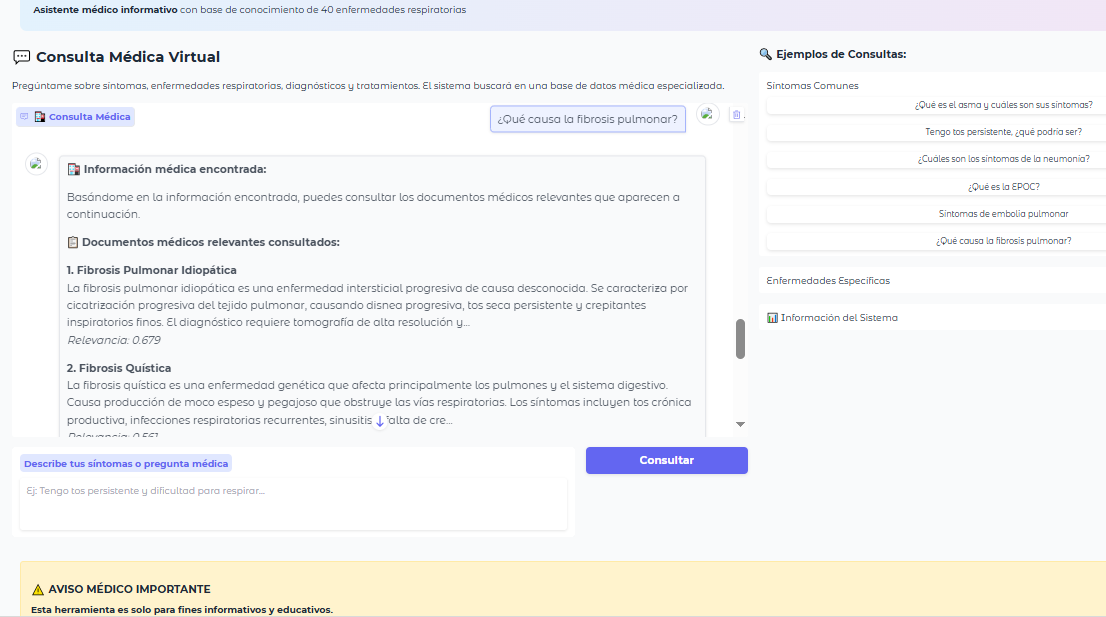

## Conclusión

El desarrollo de este sistema RAG especializado en enfermedades respiratorias ha demostrado el potencial significativo de la combinación de técnicas de recuperación de información y modelos de lenguaje generativos para abordar necesidades informativas en el ámbito médico. Al integrar una base de conocimiento sobre diversas patologías respiratorias con un modelo de embeddings eficiente y una arquitectura de búsqueda vectorial, hemos logrado construir una herramienta capaz de recuperar información relevante y generar respuestas coherentes ante consultas médicas.
En última instancia, herramientas como esta representan un paso adelante en la aplicación de la inteligencia artificial para mejorar la comprensión y el manejo de enfermedades respiratorias, siempre reconociendo su rol como complemento y no sustituto del criterio clínico profesional.